# Phineus

This demo shows the power of VENumML to do time series predict - on encrypted data! Here we will show how to model trends and seasonality in time series data using fourier transforms and linear regression. The model performs similarly to the popular timeseries forecasting model, Prophet.

Phineus, in Greek mythology, is known as a blind prophet and king of Salmydessus in Thrace. 

In [ ]:
from venumML.venumpy import small_glwe as vp
import numpy as np
import pandas as pd
import plotly
import time
from venumML.venum_tools import encrypt_array, decrypt_array
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from venumML.time_series.Phineus.phineus_timeseries import phineus_predict, reconstruct_signal, extend_date_column

# Scenario

### Secure Forecasting of Whitebox ATM Transaction Volumes

A private whitebox ATM service processes millions of customer transactions daily, including deposits, withdrawals, and balance enquiries. Accurately forecasting daily transaction volumes is crucial for to ensure that each ATM in their network is adaquetly stocked.

### Privacy Concerns

Transaction data contains sensitive customer information protected under regulations such as the Gramm-Leach-Bliley Act (GLBA) in the U.S., the General Data Protection Regulation (GDPR) in the EU, and other financial privacy laws. Unauthorized access or data breaches can result in severe legal penalties, financial losses, and reputational damage. Moreover, banks would consider transaction volume information to be proprietary, and would want to shield these numbers from external parties.

### Challenge we are solving for with VenuML

The ATM service needs to forecast future transaction volumes to optimize operational efficiency. However, it must ensure that sensitive customer data remains confidential throughout the forecasting process.

### Example Data

Below we generate example data for 3 banks for a single ATM. Feel free to play around and add more banks! 


## Generate Time Series Data 
Now, let's generate some time series data for this use case. There should be a trend, some seasonality, noise, maybe even some brownian motion! 

In this context, the parameters represent:

- An Upward Trend (`trend_slope`): Reflects the increasing volume of transactions over time.
- Seasonal Patterns (`seasonal_period, add_irregular_seasonal`): Mimics regular and irregular fluctuations due to holidays, pay cycles, and other periodic events.
- Random Noise (`noise_scale`): Represents the day-to-day variability in transaction volumes.
- Random Spikes (`num_spikes, spike_scale`): Simulates sudden surges from large transactions or unexpected market events.
- Random Walk Component (`add_random_walk`): Captures unpredictable changes resulting from external economic factors.

In [3]:
def generate_synthetic_data(names, start_date='2019-01-01', end_date='2022-01-01', freq='D', num_spikes=0, spike_scale=300, trend_slope=500, seasonal_period=365, noise_scale=50, random_seed=42, add_irregular_seasonal=True, add_random_walk=True):
    dates = pd.date_range(start_date, end_date, freq=freq)
    all_data = pd.DataFrame({'ds': dates})
    
    for i, name in enumerate(names):
        np.random.seed(random_seed + i)

        # Adding an upward trend: increment increases linearly over time
        trend = np.linspace(200, trend_slope, len(dates))
        
        # Base seasonal data
        seasonal_data = 10 * np.sin(dates.dayofyear / seasonal_period * 2 * np.pi)
        
        if add_irregular_seasonal:
            # Add more complexity to seasonal data
            seasonal_data += 5 * np.sin(dates.dayofyear / (seasonal_period / 2) * 2 * np.pi)
        
        # Add random noise
        noise = np.random.normal(scale=noise_scale, size=len(dates))
        
        # Combine components
        base_data = seasonal_data + noise + trend
        
        if add_random_walk:
            # Introduce a random walk component
            random_walk = np.cumsum(np.random.normal(scale=20, size=len(dates)))
            base_data += random_walk
        
        # Convert base_data to a numpy array to handle mutable operations
        base_data = np.array(base_data)
        
        # Introduce random spikes
        if num_spikes > 0:
            spike_indices = np.random.choice(len(dates), num_spikes, replace=False)
            spike_magnitudes = np.random.normal(scale=spike_scale, size=num_spikes)
            for j, index in enumerate(spike_indices):
                base_data[index] += spike_magnitudes[j]
        
        # Ensure all values are positive and round to the nearest multiple of 20
        base_data = np.maximum(base_data, 0)
        base_data = np.round(base_data / 20) * 20
        
        all_data[name] = base_data
    
    return all_data


In [4]:
banks = ['BankA', 'BankB', 'BankC']
data = generate_synthetic_data(banks)

Let's visualise the data:

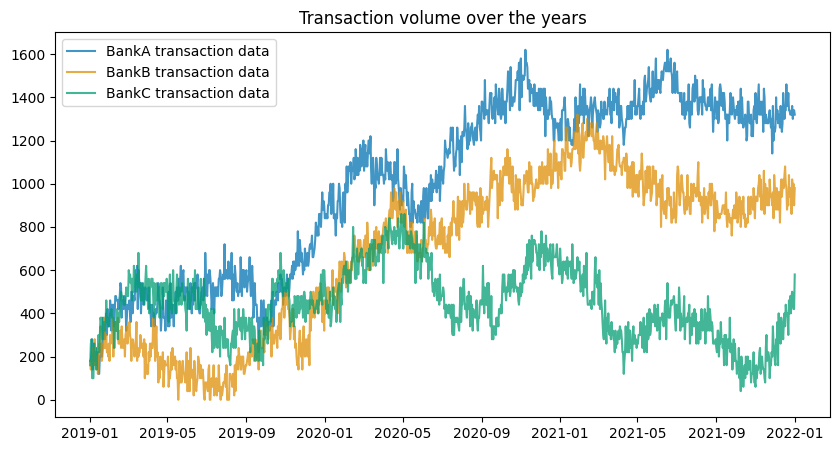

In [5]:
import seaborn as sns

# Generate a colorblind-friendly palette with the same number of colors as the number of banks
colors = sns.color_palette("colorblind", len(banks))

plt.figure(figsize=(10, 5))
for i, name in enumerate(banks):
    plt.plot(data['ds'], data[name], label=f'{name} transaction data', alpha=0.75, color=colors[i])
plt.legend()
plt.title('Transaction volume over the years')
plt.show()

## Encrypt sensitive data.


## Instantiate encrypted context 
Let's start by setting up our context, and then encrypt the "y" column. For ease of understanding, we won't be encrypting the dates. 

In [6]:
ctx = vp.SecretContext()

In [7]:
for bank in banks:
    data[bank] = data[bank].apply(lambda x: ctx.encrypt(x))

In [8]:
data['y'] = data[banks].sum(axis=1)

In [9]:
# data['total'] = data['y'].apply(lambda x: ctx.encrypt(x))

As you can see, the y column in the dataframe is now encryped

In [10]:
data

,ds,BankA,BankB,BankC,y
0,2019-01-01,<venumpy.small_glwe.Ciphertext object at 0x107...,<venumpy.small_glwe.Ciphertext object at 0x107...,<venumpy.small_glwe.Ciphertext object at 0x17f...,<venumpy.small_glwe.Ciphertext object at 0x285...
1,2019-01-02,<venumpy.small_glwe.Ciphertext object at 0x107...,<venumpy.small_glwe.Ciphertext object at 0x17f...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...
2,2019-01-03,<venumpy.small_glwe.Ciphertext object at 0x107...,<venumpy.small_glwe.Ciphertext object at 0x17f...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...
3,2019-01-04,<venumpy.small_glwe.Ciphertext object at 0x107...,<venumpy.small_glwe.Ciphertext object at 0x17f...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...
4,2019-01-05,<venumpy.small_glwe.Ciphertext object at 0x107...,<venumpy.small_glwe.Ciphertext object at 0x17f...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...
...,...,...,...,...,...
1092,2021-12-28,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...
1093,2021-12-29,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...
1094,2021-12-30,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...
1095,2021-12-31,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...,<venumpy.small_glwe.Ciphertext object at 0x285...


## Predict future trends
Now we are going to use a combination of Fourier transformers, linear regression and gradient descent to predict future trends on this time series data. This will return the complex FFT output, the trend line, the time dimension and relevant frequencies. 

In [11]:
forecast_periods = 90

In [12]:
start = time.time()
fft_values, frequencies, total_t, trend_predictions = phineus_predict(ctx, data, forecast_periods = forecast_periods ,smoothing = True, window_size=7)
end = time.time()
phineus_preds_time = end - start

## Decrypt FFT
Now, let's decrypt the FFT output and the trend line. The FFT output is a tuple of encrypted real and imaginary values. After decrypting, we will convert these values to complex numbers for ease of use. The trend line is linear fit of the data trend. 

In [13]:
def decrypt_fft(fft_values):
    return np.asarray([np.complex128(complex(re.decrypt(),im.decrypt())) for re,im in fft_values])

In [14]:
trend_predictions_decrypted = decrypt_array(trend_predictions)

In [15]:
fft_output = decrypt_fft(fft_values)

Now that we have decrypted the FFT output, we can calculate the amplitudes of the various frequency components, as well as their phase

In [16]:
amplitudes = np.abs(fft_output)

In [17]:
phases = np.angle(fft_output)

Using these values we can stitch them together into a seasonal trend. Play around with selecting how many of the frequencies you wish to keep! 

In [18]:
seasonal_trend = reconstruct_signal(amplitudes, phases, frequencies, total_t, number_of_frequencies= 25)

In [19]:
phineus_curve = trend_predictions_decrypted + seasonal_trend

## Forecast Dataframe
Now let's create a new dataframe with an extended timeline that holds these predicted values. 

In [20]:
future_forecast = extend_date_column(data, 'ds', extension_count = forecast_periods, frequency= 'D')

In [21]:
future_forecast['yhat'] = phineus_curve

## Decrypt original data
Let's see how our model performed by decrypted the original data.

In [22]:
data["y"] = data.y.apply(lambda x: ctx.decrypt(x))

In [23]:
rmse_custom = mean_squared_error(data['y'], future_forecast['yhat'][:len(data)], squared=False)

print(rmse_custom)

135.40081641923547


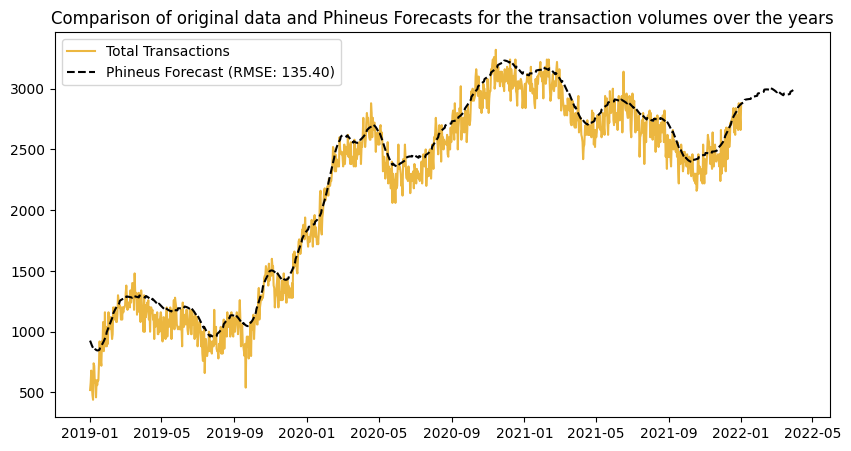

In [24]:
import matplotlib.pyplot as plt

colors = ['#E69F00',  '#56B4E9', '#000000']  

plt.figure(figsize=(10, 5))
plt.plot(data['ds'], data['y'], label='Total Transactions', alpha=0.75, color=colors[0])  
plt.plot(future_forecast['ds'], future_forecast['yhat'], label=f'Phineus Forecast (RMSE: {rmse_custom:.2f})', linestyle='--', color=colors[2])  

plt.legend()
plt.title('Comparison of original data and Phineus Forecasts for the transaction volumes over the years')
plt.show()

Pretty good no? :-) 

# Compare to Prophet

Let's now compare out model against Prophet, a well known time series prediction tool for plaintext data.

In [25]:
m= Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(data)
future = m.make_future_dataframe(periods=forecast_periods)
start = time.time()
forecast_prophet = m.predict(future)
end = time.time()
prophet_preds_time = end - start

13:34:46 - cmdstanpy - INFO - Chain [1] start processing
13:34:46 - cmdstanpy - INFO - Chain [1] done processing


## Calculate error
To help us quantify the efficacy of these models, we can calculate the RMSE.

In [26]:
# Calculate RMSE for the historical fit
rmse_prophet = mean_squared_error(data['y'], forecast_prophet.loc[:len(data)-1, 'yhat'], squared=False)

## Plot curves 
Now let's plot the results:

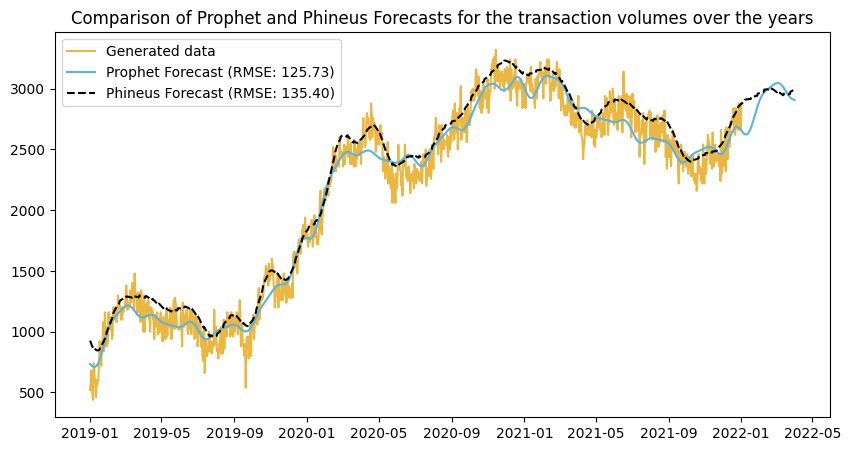

In [27]:
import matplotlib.pyplot as plt

colors = ['#E69F00',  '#56B4E9', '#000000']  

plt.figure(figsize=(10, 5))
plt.plot(data['ds'], data['y'], label='Generated data', alpha=0.75, color=colors[0])  
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label=f'Prophet Forecast (RMSE: {rmse_prophet:.2f})', color=colors[1])  
plt.plot(future_forecast['ds'], future_forecast['yhat'], label=f'Phineus Forecast (RMSE: {rmse_custom:.2f})', linestyle='--', color=colors[2])  

plt.legend()
plt.title('Comparison of Prophet and Phineus Forecasts for the transaction volumes over the years')
plt.show()


Not bad for a blind Prophet! 